# Goal

* making a heatmap of l2fc values for incorprator OTUs
  * grouping by pvclust cluster ID

# Setting variables

In [1]:
import os
%load_ext rpy2.ipython
#%load_ext pushnote

In [2]:
%%R
workDir = '/home/chantal/Chazy/Bulk/ITS/'
figDir = '/home/chantal/Chazy/Bulk/ITS/data/figs/'


# physeq file
physeqDir = '/home/chantal/Chazy/data/phyloseq/ITS/'
physeqBulk = 'bulk-core' 

# params
padj.cutoff = 0.05   # adjusted p-value cutoff for selecting incorporators
nprocs = 10

# Init

In [3]:
%Rpull workDir
workDir = workDir[0]
if not os.path.isdir(workDir):
    os.makedirs(workDir)
    
%Rpull figDir
figDir = figDir[0]
if not os.path.isdir(figDir):
    os.makedirs(figDir)    
    
%cd $workDir    

/home/chantal/Chazy/Bulk/ITS


In [4]:
%%R
library(phyloseq)
library(dplyr)
library(tidyr)
library(ggplot2)
library(ComplexHeatmap)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: grid

  res = super(Function, self).__call__(*new_args, **new_kwargs)


# Loading files

## prefractionation abundances

In [5]:
%%R 
F = file.path(physeqDir, physeqBulk)
physeq.bulk = readRDS(F)
physeq.bulk.m = physeq.bulk %>% sample_data

#physeq.bulk = physeq.bulk %>% transform_sample_counts(function(x) x/sum(x))

physeq.bulk = prune_samples(physeq.bulk.m$Land_Management %in% c ('NTR', 'NTH'),
                           physeq.bulk)

physeq.bulk <- subset_taxa(physeq.bulk, Rank1 =="k__Fungi") 

physeq.bulk = prune_taxa(names(sort(taxa_sums(physeq.bulk),TRUE)[1:200]), physeq.bulk)
    
physeq.bulk.m = physeq.bulk %>% sample_data

        
print(physeq.bulk)

  

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 200 taxa and 88 samples ]
sample_data() Sample Data:       [ 88 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 200 taxa by 7 taxonomic ranks ]


In [6]:
%%R
mdf = psmelt(physeq.bulk)

mdf2 = mdf %>% group_by(Sample_Date, OTU) %>%  summarise(sumAbundance = sum(Abundance)) %>%
            mutate(relab = sqrt(sumAbundance/sum(sumAbundance)))
mdf3 = mdf2 %>% select(Sample_Date, OTU, relab) %>% spread(Sample_Date, relab) %>%
        as.data.frame

rownames(mdf3) = mdf3$OTU
mdf3$OTU = NULL

head(mdf3) %>% as.matrix

           10/27/15    10/29/14   11/25/15   11/26/14    4/30/15     6/17/15
OTU.1001 0.02767739 0.008769990 0.06656797 0.01968316 0.03010864 0.015211347
OTU.1015 0.02272950 0.008769990 0.02564103 0.00508217 0.02844999 0.006802721
OTU.102  0.20938554 0.055466286 0.13499945 0.07133165 0.13246824 0.164395183
OTU.1022 0.07974895 0.013866572 0.07378202 0.01136408 0.00000000 0.023565317
OTU.1035 0.02110381 0.006201319 0.03055481 0.05056695 0.01138000 0.016663196
OTU.1036 0.02924230 0.136005551 0.08542734 0.01016434 0.00000000 0.031907590
            7/10/14    7/16/15     8/13/15     9/23/15     9/24/14
OTU.1001 0.01116900 0.00000000 0.012858612 0.011319433 0.006460089
OTU.1015 0.01934528 0.01984043 0.031869798 0.027024776 0.024171438
OTU.102  0.10113962 0.13048006 0.103212752 0.093067495 0.079906882
OTU.1022 0.05749596 0.04090209 0.004860099 0.003579519 0.000000000
OTU.1035 0.04361635 0.00000000 0.011904762 0.008767995 0.025840354
OTU.1036 0.00000000 0.00000000 0.000000000 0.000000000 0.00

In [7]:
%%R
max(mdf3$sumAbundance)
min(mdf3$sumAbundance)

[1] Inf


## pvclust

Creating a temporary cluster...done:
socket cluster with 39 nodes on host ‘localhost’
Multiscale bootstrap... Done.


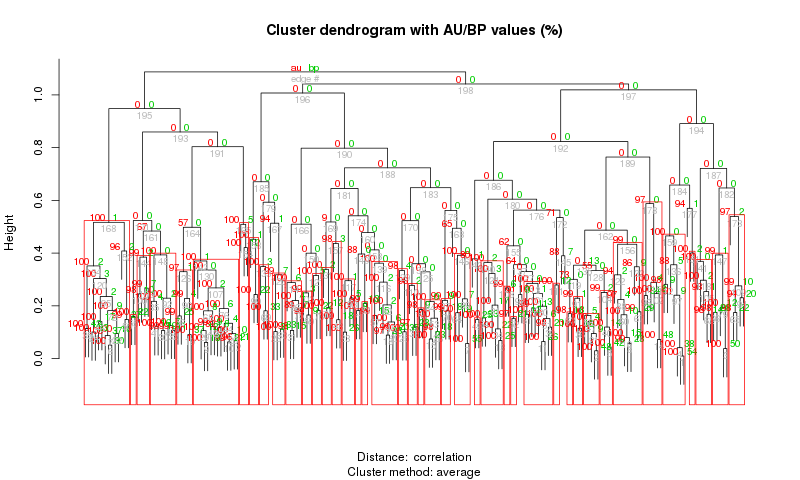

In [8]:
%%R -w 800 
#alter cut-off
pvc.res = pvclust::pvclust(mdf3 %>% t, 
                           method.hclust='average', 
                           method.dist='correlation',
                           nboot = 1000,
                           #nboot=10000, 
                           parallel=TRUE)
plot(pvc.res, labels=FALSE)
pvclust::pvrect(pvc.res)

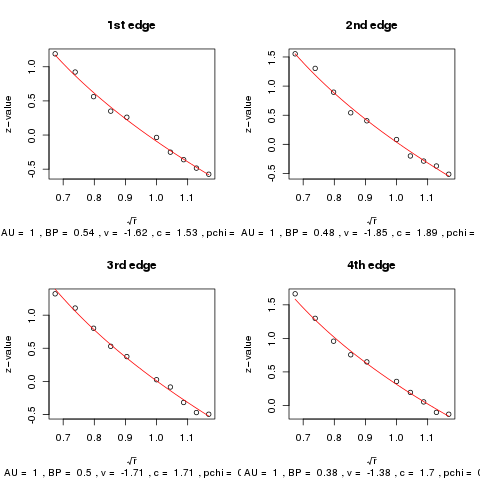

In [9]:
%%R
pvclust::msplot(pvc.res, edges=c(1,2,3,4))

In [10]:
%%R
# number of significant clusters
pvc.clusts = pvclust::pvpick(pvc.res)
pvc.clusts$clusters %>% length

[1] 42


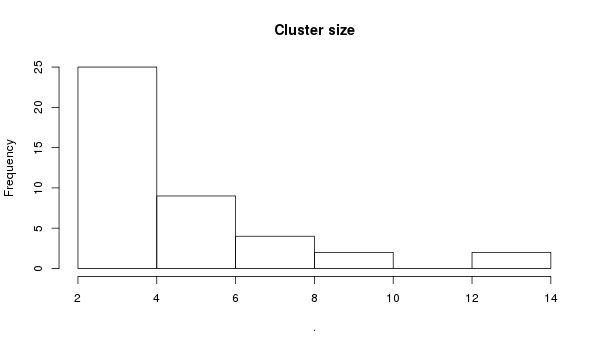

In [11]:
%%R -w 600 -h 350
# size of each cluster
do.call(rbind, lapply(pvc.clusts$clusters, length)) %>% 
    as.vector %>% 
    hist(binwidth=1, main='Cluster size')

In [12]:
%%R
# making dataframe of clusters
clusts = matrix(ncol=2)
for(i in 1:length(pvc.clusts$clusters)){
    x = pvc.clusts$clusters[[i]]
    x = x %>% as.matrix
    x = cbind(x, rep(i, nrow(x)))
    clusts = rbind(clusts, x)
}
df.pvc.clusts = clusts[2:nrow(clusts),] %>% as.data.frame
colnames(df.pvc.clusts) = c('OTU', 'pvc.cluster.ID')
df.pvc.clusts %>% head

        OTU pvc.cluster.ID
1  OTU.1015              1
2   OTU.269              1
3   OTU.224              2
4 OTU.55675              2
5   OTU.227              3
6    OTU.66              3


## Setting up column ordering/annotation

In [13]:
%%R
# ordering
col.order = c('7/10/14', 
              '9/24/14', 
              '10/29/14', 
              '11/26/14', 
              '4/30/15', 
              '6/17/15', 
              '7/16/15', 
              '8/13/15', 
              '9/23/15', 
              '10/27/15', 
              '11/25/15')


In [14]:
%%R -h 250 -w 600
# making column annotation of substrate & day

df.sd = data.frame(Sample_date = col.order)

Substrate.cols = c(
'7/10/14' = "#FF0000FF",
'9/24/14' = "#FF9900FF",
'10/29/14' = "#CCFF00FF",
'11/26/14' = "#33FF00FF",
'4/30/15' = "#00FF66FF",
'6/17/15' = "#00FFFFFF",
'7/16/15' = "#0066FFFF",
'8/13/15' = "#3300FFFF",
'9/23/15' = "#CC00FFFF",
'10/27/15' = "#FF0099FF",
'11/25/15' =  '#CC3333'
)

#Day.cols = c(
#"D1" = "#F2F2F2FF",
#"D3" = "#BCBCBCFF",
#"D6" = "#8A8A8AFF",
#"D14" = "#5A5A5AFF",
#"D30" = "#2E2E2EFF",
#"D48" = "#000000FF"
#)

ha.col = HeatmapAnnotation(df = df.sd, 
  col = list(Substrate = Substrate.cols),
  na_col = "grey")


## Row annotation by phylum

In [15]:
%%R
tax = as.data.frame(tax_table(physeq.bulk))
tax$OTU = rownames(tax)

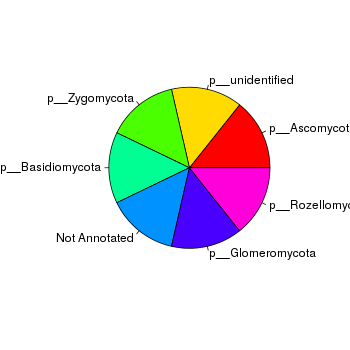

In [16]:
%%R -w 350 -h 350
df.l2fc.phy = tax %>%
    dplyr::select(OTU, Rank2) %>%
    distinct(OTU, Rank2) 
rownames(df.l2fc.phy) = df.l2fc.phy$OTU

df.l2fc.phy = df.l2fc.phy[rownames(mdf3),]
df.l2fc.phy = df.l2fc.phy %>%
    dplyr::select(Rank2) %>%
    mutate(Rank2 = Rank2 %>% as.character)
df.l2fc.phy[is.na(df.l2fc.phy)] = 'Not Annotated'

tax = df.l2fc.phy$Rank2 %>% unique
tax[is.na(tax)] = "Not Annotated"
n.tax = tax %>% length
colors = rainbow(n.tax)
tax.cols = setNames(colors, tax)

ha.row = HeatmapAnnotation(df = df.l2fc.phy, 
                           col = list(Rank2 = tax.cols),
                           na_col = 'grey',
                           which='row', 
                           width=unit(4, 'mm'))

pie(rep(1, n.tax), labels=tax, col=colors)

## preFrac heatmap

%%R -h 800 -w 200
# adding taxa found in fractions but not in bulk-abundances
not.in = setdiff(rownames(df.bulk), rownames(df.bulk))
df.not.in = matrix(nrow=length(not.in), ncol=ncol(df.bulk)) %>% as.data.frame
colnames(df.not.in) = colnames(df.bulk)
rownames(df.not.in) = not.in
df.not.in[is.na(df.not.in)] = 0

# filtering and ordering
df.bulk.f = rbind(df.bulk, df.not.in)
df.bulk.f = df.bulk.f[rownames(df.l2fc.w),] 

# transforming
df.bulk.f = apply(df.bulk.f, 1, function(x) x / sum(x)) %>% t
df.bulk.f[is.nan(df.bulk.f)] = 0

# column order
pf.col.order = c('D1', 'D3', 'D6', 'D14', 'D30', 'D48')
    
# making heatmap
min.abnd = df.bulk.f %>% as.matrix %>% as.vector %>% min
max.abnd = df.bulk.f %>% as.matrix %>% as.vector %>% max
h.pf = Heatmap(df.bulk.f %>% as.matrix, 
        name='Pre-Fractionation\nAbundance', 
        col = circlize::colorRamp2(c(min.abnd, max.abnd), 
                                   c("black", "green")),
        show_row_names=FALSE,
        combined_name_fun=NULL,
        cluster_columns=FALSE,
        cluster_rows=FALSE,
        column_order=pf.col.order)
h.pf

## Making heatmap

In [17]:
%%R
# dataframe for spliting by pvclust clusterID
df.sp = df.pvc.clusts
rownames(df.sp) = df.sp$OTU %>% as.vector
df.sp = df.sp[rownames(mdf3),]
df.sp$OTU = NULL
df.sp %>% head(n=4)

         pvc.cluster.ID
OTU.1001              4
OTU.1015              1
OTU.102              42
OTU.1022              5


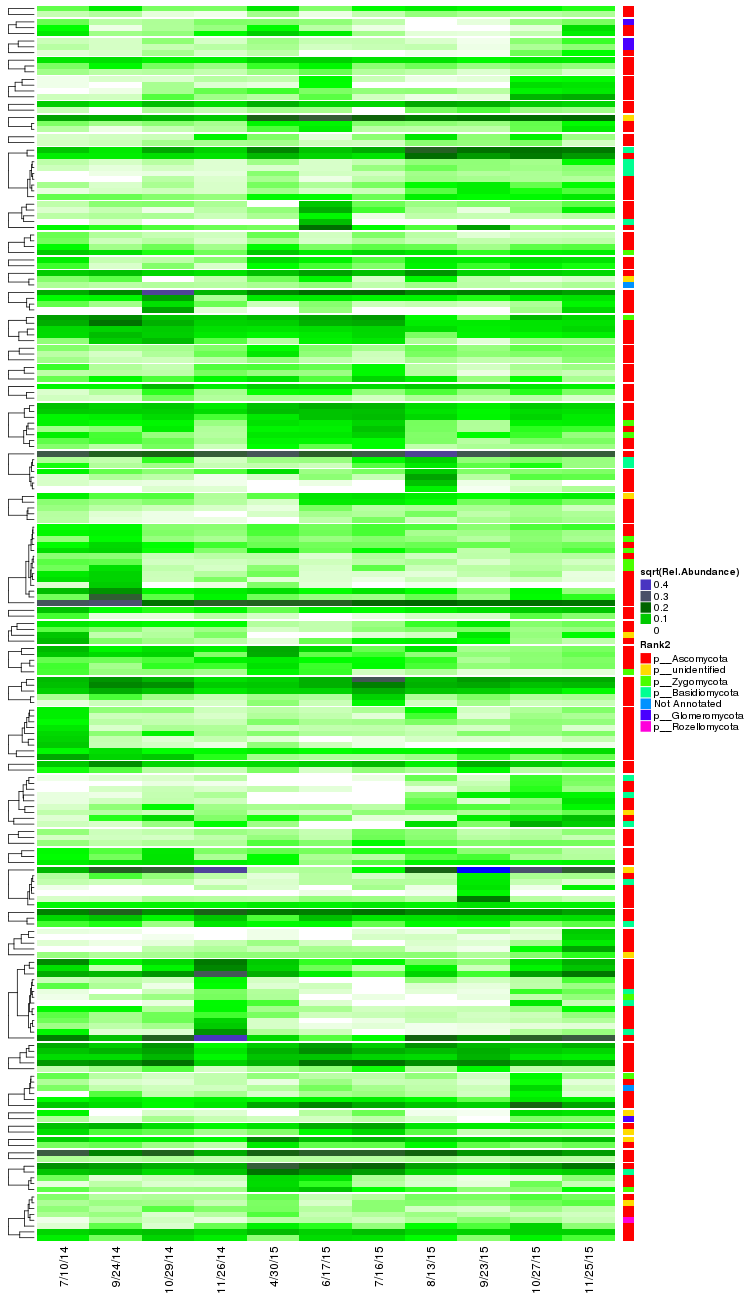

In [22]:
%%R -h 1300 -w 750

min.abnd = mdf3 %>% as.matrix %>% as.vector %>% min
max.abnd = mdf3 %>% as.matrix %>% as.vector %>% max

h = Heatmap(mdf3 %>% as.matrix, 
        name='sqrt(Rel.Abundance)', 
        col = circlize::colorRamp2(c(min.abnd, 0.05, 0.2, max.abnd), 
                                   c("white", "green", 'dark green', 'blue')),
        show_row_names=FALSE,
        split=df.sp,
        combined_name_fun=NULL,
        cluster_columns=FALSE,
        column_order=col.order,
        gap=unit(0.6, "mm"))

h  + ha.row

### Filtering out low-richness clusters

In [ ]:
%%R -w 650 -h 350
df.pvc.clusts.s = df.pvc.clusts %>%
    group_by(pvc.cluster.ID) %>%
    summarize(n.OTU = n()) %>%
    ungroup()

ggplot(df.pvc.clusts.s, aes(n.OTU)) +
    geom_histogram(binwidth=1) +
    labs(x='Number of OTUs') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [ ]:
%%R
# cutoff for number of OTUs that must be in cluster
n.OTU.cut = 8

df.l2fc.f.w = inner_join(df.l2fc, df.pvc.clusts, c('OTU'='OTU')) %>%
    group_by(pvc.cluster.ID) %>%
    mutate(OTU.per.clust = OTU %>% unique %>% length) %>%
    filter(OTU.per.clust >= n.OTU.cut) %>%
    ungroup() %>%
    mutate(Day = gsub('^', 'D', Day)) %>%
    unite(Substrate_Day, Substrate, Day, sep='_') %>%
    dplyr::select(OTU, Substrate_Day, log2FoldChange) %>%
    spread(Substrate_Day, log2FoldChange, fill=0) 

rownames(df.l2fc.f.w) = df.l2fc.f.w$OTU
df.l2fc.f.w$OTU = NULL
df.l2fc.f.w %>% head(n=3) %>% print

# dataframe for spliting by pvclust clusterID
df.sp = df.pvc.clusts
rownames(df.sp) = df.sp$OTU %>% as.vector
df.sp = df.sp[rownames(df.l2fc.f.w),] 
df.sp$OTU = NULL
df.sp %>% head(n=3) %>% print

In [ ]:
%%R -h 800 -w 200

df.bulk.f = df.bulk.f[rownames(df.l2fc.f.w),] 

# transforming
df.bulk.f = apply(df.bulk.f, 1, function(x) x / sum(x)) %>% t
df.bulk.f[is.nan(df.bulk.f)] = 0

    
# column order
pf.col.order = c('D1', 'D3', 'D6', 'D14', 'D30', 'D48')
    
# making heatmap
min.abnd = df.bulk.f %>% as.matrix %>% as.vector %>% min
max.abnd = df.bulk.f %>% as.matrix %>% as.vector %>% max
h.pf = Heatmap(df.bulk.f %>% as.matrix, 
        name='Pre-Fractionation\nAbundance', 
        col = circlize::colorRamp2(c(min.abnd, max.abnd), 
                                   c("black", "green")),
        show_row_names=FALSE,
        combined_name_fun=NULL,
        cluster_columns=FALSE,
        cluster_rows=FALSE,
        column_order=pf.col.order)
h.pf

In [ ]:
%%R -w 350 -h 350
# taxonomy annotation
df.l2fc.phy = df.l2fc %>%
    dplyr::select(OTU, Rank2) %>%
    distinct(OTU, Rank2) 
rownames(df.l2fc.phy) = df.l2fc.phy$OTU

rownames(df.l2fc.phy) = df.l2fc.phy$OTU
df.l2fc.phy = df.l2fc.phy[rownames(df.l2fc.f.w),]
df.l2fc.phy = df.l2fc.phy %>%
    dplyr::select(Rank2) %>%
    mutate(Rank2 = Rank2 %>% as.character)

ha.row = HeatmapAnnotation(df = df.l2fc.phy, 
                           col = list(Rank2 = tax.cols),
                           na_col = 'grey',
                           which='row', 
                           width=unit(4, 'mm'))

pie(rep(1, n.tax), labels=tax, col=colors)

In [ ]:
%%R -h 700 -w 700
# heatmap: trimmed

#min.l2fc = df.l2fc.f.w %>% as.vector %>% min
#max.l2fc = df.l2fc.f.w %>% as.vector %>% max

h = Heatmap(df.l2fc.f.w %>% as.matrix, 
        name='l2fc', 
        col = circlize::colorRamp2(c(-3, 0, 3), 
                                   c("red", "black", "green")),
        show_row_names=FALSE,
        split=df.sp,
        combined_name_fun=NULL,
        cluster_columns=FALSE,
        column_order=col.order,
        gap=unit(0.6, "mm")
        )

h + h.pf + ha.row

In [ ]:
%%R -i figDir

htmp.file = file.path(figDir, 'htmp_nOTUcut8.pdf')
pdf(htmp.file, width=10, height=11)
draw(h + h.pf + ha.row)
dev.off()
cat('File written:', htmp.file, '\n')


htmp.file = file.path(figDir, 'htmp_nOTUcut8.tiff')
tiff(htmp.file, width=10, height=11, units='in', res=150)
draw(h + h.pf + ha.row)
dev.off()
cat('File written:', htmp.file, '\n')

# Plotting l2fc dynamics for each pvclust clust

In [ ]:
%%R

df.l2fc.pvc = inner_join(df.pvc.clusts, df.l2fc, c('OTU' = 'OTU'))

df.l2fc.pvc.s = df.l2fc.pvc %>%
    group_by(Substrate, Day, pvc.cluster.ID) %>%
    summarize(median_l2fc = median(log2FoldChange)) %>%
    ungroup() %>%
    complete(Substrate, Day, pvc.cluster.ID) %>%
    mutate(median_l2fc = ifelse(is.na(median_l2fc), 0, median_l2fc))



# majority rule
maj.rule = function(x){
    y = x %>% table %>% sort(decreasing=TRUE) %>% names
    y[1] 
}
df.maj.rule = df.l2fc.pvc %>% 
    filter(Incorporator == 1) %>%
    group_by(pvc.cluster.ID) %>%
    summarize(Day.maj.rule = maj.rule(Day),
              Sub.maj.rule = maj.rule(Substrate)) %>%
    ungroup() %>%
    unite(maj.rule, Day.maj.rule, Sub.maj.rule, sep='_', remove=FALSE) %>%
    mutate(maj.rule = gsub('^', 'D', maj.rule))

df.l2fc.pvc.s = inner_join(df.l2fc.pvc.s, df.maj.rule, c('pvc.cluster.ID' = 'pvc.cluster.ID')) 


df.l2fc.pvc.s$pvc.cluster.ID = reorder(df.l2fc.pvc.s$pvc.cluster.ID, 
                                       df.l2fc.pvc.s$pvc.cluster.ID %>% as.numeric)

df.l2fc.pvc.s %>% head

In [ ]:
%%R -w 800 -h 300

make.plot = function(df, Day){
    Day.maj.rule = df$Day.maj.rule2 %>% unique
    Sub.maj.rule = df$Sub.maj.rule2 %>% unique
    title = paste0('MR-Day: ', Day.maj.rule, ', MR-Substrate: ', Sub.maj.rule, collapse=' ')
    
    p = ggplot(df, aes(Day, median_l2fc, color=Substrate)) +
        geom_point() +
        geom_line() +
        geom_hline(yintercept=0, alpha=0.25) +
        labs(y='Median log2 fold change', title=title) +
        facet_wrap(~ pvc.cluster.ID, ncol=6) +
        theme_bw() +
        theme(
            text = element_text(size=16)
        )
    print(p)
    return(1)
}


df.l2fc.pvc.s.p = df.l2fc.pvc.s %>% 
    mutate(Day.maj.rule2 = Day.maj.rule, 
           Sub.maj.rule2 = Sub.maj.rule) %>%
    group_by(Day.maj.rule, Sub.maj.rule) %>%
    nest %>%
    mutate(plot = lapply(data, make.plot, Day = Day.maj.rule))

In [ ]:
%%R -w 800 -h 1500

ggplot(df.l2fc.pvc.s, aes(Day, median_l2fc, color=Substrate)) +
    geom_point() +
    geom_line() +
    geom_hline(yintercept=0, alpha=0.25) +
    labs(y='Median log2 fold change') +
    facet_wrap(maj.rule ~ pvc.cluster.ID, ncol=6) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

## Complex Heatmap attempt

In [ ]:
%%R
df.bulk = physeq.bulk %>% otu_table %>% as.data.frame
df.bulk$OTU = rownames(df.bulk)
df.bulk$OTU = NULL
colnames(df.bulk) = physeq.bulk.m$Sample_Date
df.bulk %>% head(n=3) 

In [ ]:
%%R
mdf = psmelt(physeq.bulk)
head(mdf)

In [ ]:
%%R
mdf2 = mdf %>% group_by(Sample_Date, OTU) %>% 
        summarise(SumAbundance = sum(Abundance))


In [ ]:
%%R
head(mdf2) %>% as.data.frame

In [ ]:
%%R
mdf3 = mdf2 %>% select(Sample_Date, OTU, SumAbundance) %>% spread(OTU, SumAbundance)
rownames(mdf3) = mdf3$Sample_Date
mdf3$Sample_Date = NULL

head(mdf3) %>% as.data.frame

In [ ]:
%%R
df.yesno = df.bulk
df.yesno[df.yesno > 0] = 1
#df.yesno = df.yesno[df.yesno == 0] = 0 
head(df.yesno)

In [ ]:
%%R
df.yesno = as.matrix(df.yesno)
df.bulk = as.matrix(mdf3)

In [ ]:
%%R
rownames(mdf3)

In [ ]:
%%R
mdf = psmelt(physeq.bulk)

mdf2 = mdf %>% group_by(Sample_Date, OTU) %>% summarise(SumAbundance = sum(Abundance)) %>%
        mutate(relative.abundance = SumAbundance / sum(SumAbundance))


mdf3 = mdf2 %>% select(Sample_Date, OTU, relative.abundance) %>% spread(Sample_Date, relative.abundance) %>%
        as.data.frame

rownames(mdf3) = mdf3$OTU
mdf3$OTU = NULL

df.bulk = as.matrix(mdf3)

head(mdf3) 

In [ ]:
%%R
mdf$Sample_Date = factor(mdf$Sample_Date, 
                                        levels = c('7/10/14', '9/24/14', '10/29/14', '11/26/14', 
                                                  '4/30/15', '6/17/15', '7/16/15', '8/13/15', 
                                                  '9/23/15', '10/27/15', '11/25/15'))
df.split = as.data.frame(unique(mdf$Sample_Date))
df.split$num = c(1,2,3,4,5,6,7,8,9,10,11)
head(df.split)

In [ ]:
%%R -w 1000 -h 1000
#f1 = circlize::colorRamp2(seq(min(df.bulk), max(df.bulk), length = 3), c("blue", "#EEEEEE", "red"))

heatmap(df.bulk,   col = circlize::colorRamp2(c(min(df.bulk), max(df.bulk)), 
                                   c("red", "green")))
#Change row order...

In [ ]:
%%R -w 1000 -h 1000

mdf2 = mdf %>% group_by(OTU) %>% mutate(SumAbundance = sum(Abundance)) %>%
        mutate(relative.abundance = SumAbundance / sum(SumAbundance))


mdf3 = mdf2 %>% select(Sample_Date, OTU, relative.abundance) %>% spread(OTU, relative.abundance) %>%
        as.data.frame

head(mdf2)


In [ ]:
%%R
head(mdf2)

In [ ]:
%%R
df.bulk.2 = as.matrix(mdf3)

ha = HeatmapAnnotation(df = df.bulk.2, col = list(type = c("7/10/14" =  "red", '9/24/14' = "blue",'10/29/14' = 'green',
                                                    '11/24/14' = 'yellow'
                                                   '4/30/15' = 'orange', '6/17/15' = 'purple', '7/16/15' = 'pink',
                                                   '8/13/15' = 'black', '9/23/15' = 'turquoise', '10/27/15' = 'brown',
                                                   '11/25/15' = 'grey')))


heatmap(df.bulk.2, bottom_annotation = ha)